# CO<sub>2</sub> Forecast using SARIMA Model

**This notebook is an example of applying a SARIMA model to a time series using statsmodels in python.  The version of statsmodels used here is in development (0.80, https://github.com/statsmodels/statsmodels), but it provides a seasonal term for ARIMA modeling, so I chose to give it a try.**

**The time series is the monthly mean atmospheric carbon dioxide (CO2) concentration measured at Mauna Loa Observatory, Hawaii, and downloaded from ESRL at NOAA in October, 2016 (https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).**

**The data are provided by Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (www.scrippsco2.ucsd.edu/).**

## Workspace setup

In [1]:
# Set up the workspace

import sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,8

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson as DW
from statsmodels.regression._prediction import get_prediction
from datetime import datetime

## Function definitions

<b>
In order to quickly examine the dataset and test variations on model parameters, I made a few functions, but these are not very reusable for other datasets (yet).

</b>

In [2]:
# Function for testing stationarity following the example of Analytics Vidhya 
# (https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

def test_stationarity3(time_series, plot_title, y_lim1, y_lim2, y_lim3):
    
    range1a = '1958'
    range1b = '1977'
    range2a = '1978'
    range2b = '1995'
    range3a = '1996'
    range3b = '2016'
    
    # Calculate rolling stats
    rol_mean = time_series.rolling(window=12).mean()
    rol_std = time_series.rolling(window=12).std()
            
    ts1 = time_series[range1a:range1b]
    ts2 = time_series[range2a:range2b]
    ts3 = time_series[range3a:range3b]
            
    rol_mean1 = rol_mean[range1a:range1b]
    rol_mean2 = rol_mean[range2a:range2b]
    rol_mean3 = rol_mean[range3a:range3b]
        
    rol_std1 = rol_std[range1a:range1b]
    rol_std2 = rol_std[range2a:range2b]
    rol_std3 = rol_std[range3a:range3b]
    
    # Plot rolling stats
    fig = plt.figure()
    plt.subplot(311)
    plt.plot(ts1, color='blue', label='Data')
    plt.plot(rol_mean1, color='red', label='Rolling Mean')
    plt.plot(rol_std1, color='black', label='Roling Std Dev')
    plt.legend(loc='best')
    p_title = plot_title + ' (Stationarity Test)'
    plt.title(p_title)
    if y_lim1:
        plt.ylim(y_lim1)
    
    plt.subplot(312)
    plt.plot(ts2, color='blue', label='Data')
    plt.plot(rol_mean2, color='red', label='Rolling Mean')
    plt.plot(rol_std2, color='black', label='Roling Std Dev')
    if y_lim2:
        plt.ylim(y_lim2)
    
    plt.subplot(313)
    plt.plot(ts3, color='blue', label='Data')
    plt.plot(rol_mean3, color='red', label='Rolling Mean')
    plt.plot(rol_std3, color='black', label='Roling Std Dev')
    plt.xlabel('Year')
    if y_lim3:
        plt.ylim(y_lim3)

    plt.show(block=False)
       
    # Run Dickey-Fuller test
    print('Results of Dickey-Fuller test:')
    d_f_test = adfuller(time_series, autolag='AIC')
    d_f_output = pd.Series(d_f_test[0:4],
                          index=['Test Statistic','p-value',
                                 'Lags Used','Number of Observations Used'])
    for k,v in sorted(d_f_test[4].items()):
        d_f_output['Critical Value (%s)'%k] = v
    print(d_f_output)

In [3]:
# Function for making quick autocorrelation plots

def test_acfs(time_series,num_lags):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    fig = plot_acf(time_series, lags=num_lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(time_series, lags=num_lags, ax=ax2)

In [4]:
# Function for making a sarima model, plotting the results, and
# displaying the results summary.
# Using statsmodels 0.8.0 (dev) because it has a seasonal term

def make_SARIMAX(time_series, terms1, terms2):
    # terms: (p,d,q) and (P,D,Q,s)
    # s is the peridicity (e.g., 12 for 12 months)
    model = sm.tsa.SARIMAX(time_series, order=(terms1[0],terms1[1],terms1[2]), 
                               seasonal_order=(terms2[0],terms2[1],terms2[2],
                                               terms2[3]))
    model_results = model.fit()
    model_fit = model_results.predict()
            
    ts1 = time_series['1958-04-15':'1977-12-15']
    ts2 = time_series['1976-01-15':'1995-12-15']
    ts3 = time_series['1996-01-15':'2016-09-15']
    
    model_fit1 = model_fit['1958-04-15':'1977-12-15']
    model_fit2 = model_fit['1976-01-15':'1995-12-15']
    model_fit3 = model_fit['1996-01-15':'2016-09-15']
    
    # Visualize the model
    fig = plt.figure()
    plt.subplot(311)
    plt.plot(ts1, label='data')
    plt.plot(model_fit1, label='model')
    plt.legend(loc='best')
    
    plt.subplot(312)
    plt.plot(ts2, label='data')
    plt.plot(model_fit2, label='model')
    plt.ylabel('CO2 concentration (ppm)')
    plt.legend(loc='best')
    
    plt.subplot(313)
    plt.plot(ts3, label='data')
    plt.plot(model_fit3, label='model')
    plt.xlabel('Year')
    plt.legend(loc='best')

    # Quantify the model
    print(model_results.summary())
    
    return model, model_fit, model_results

In [5]:
# Function for quickly comparing the prediction with the 
# original series.  Includes a subplot of std err of mean,
# which is handy for seeing where the calibration data
# stops and the forecast (prediction) begins.

def compare_prediction(orig,pred):
    fig = plt.figure()
    plt.subplot(211)
    plt.plot(orig, 'b', label='Data')
    plt.plot(pred['mean'], 'g', label='Prediction')
    plt.plot(pred['mean_ci_lower'], 'r:', label='95% CI')
    plt.plot(pred['mean_ci_upper'], 'r:', label='_nolegend_')
    plt.ylabel('CO2 concentration (ppm)')
    plt.legend(loc='best')
    
    plt.subplot(212)
    plt.plot(pred['mean_se'], label='Std Error of Mean')
    plt.xlabel('Year')
    plt.ylabel('Standard Error of Mean')

## Load the data

**
Let's get the data and have a look at it.
**

In [6]:
# Get the data and have a quick look.
df = pd.read_csv('co2-ppm-mauna-loa-1958_03-2016_09.csv')
print(df.head())
print()
print(df.dtypes)

   Year  Month  Decimal Date  Average  Interpolated  Trend (Seasonal Corr)  \
0  1958      3      1958.208   315.71        315.71                 314.62   
1  1958      4      1958.292   317.45        317.45                 315.29   
2  1958      5      1958.375   317.50        317.50                 314.71   
3  1958      6      1958.458   -99.99        317.10                 314.85   
4  1958      7      1958.542   315.86        315.86                 314.98   

   # Days  
0      -1  
1      -1  
2      -1  
3      -1  
4      -1  

Year                       int64
Month                      int64
Decimal Date             float64
Average                  float64
Interpolated             float64
Trend (Seasonal Corr)    float64
# Days                     int64
dtype: object


In [7]:
# Because I'm using the monthly average CO2 (interpolated for missing months),
# I'll use the 15th day of the month (average day for most months) as the day 
# value in the date index.  A new dataframe with just the mean CO2 values will
# help clean things up too.

date_index = pd.to_datetime({'year':df['Year'], 'month':df['Month'], 'day':'15'})
cols = ['interpolated_CO2']
data = pd.DataFrame(np.array(df['Interpolated']), index=date_index, columns=cols)

print(data.head())
print()
print(data.tail())
print()
print(data.dtypes)

            interpolated_CO2
1958-03-15            315.71
1958-04-15            317.45
1958-05-15            317.50
1958-06-15            317.10
1958-07-15            315.86

            interpolated_CO2
2016-05-15            407.70
2016-06-15            406.81
2016-07-15            404.39
2016-08-15            402.25
2016-09-15            401.03

interpolated_CO2    float64
dtype: object


**
I'll use a portion of the data for calibrating the model, and I'll save the rest of it for testing (holdout data).
**

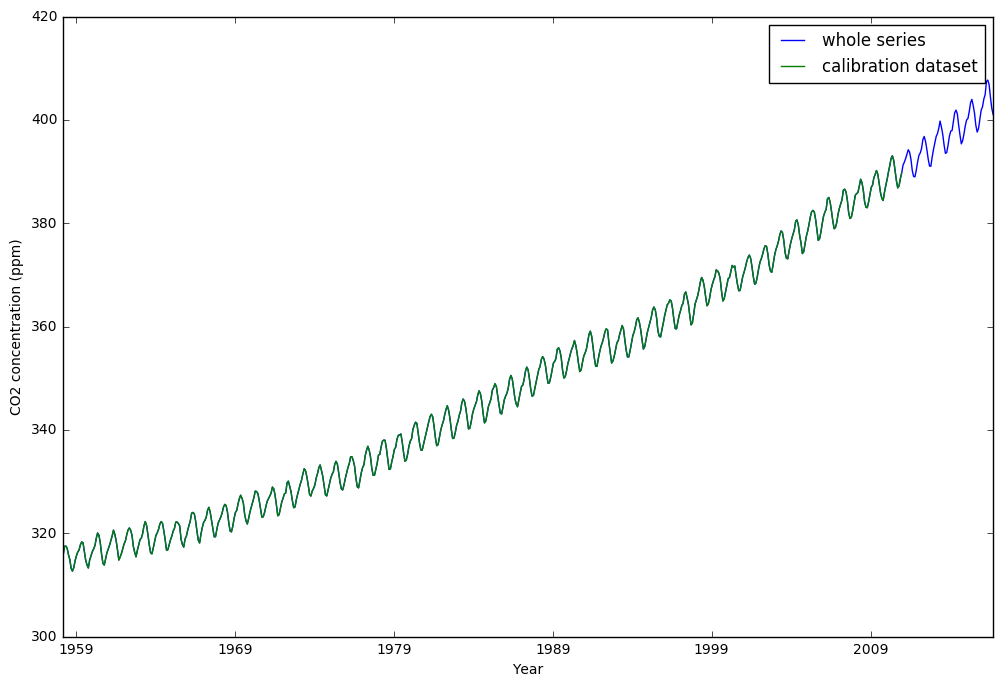

In [8]:
# Plot the portion of the data to be used for calibration
# fig = plt.figure(figsize=(15,8))
plt.plot(data, label='whole series')
plt.plot(data[:'2010'], label='calibration dataset')
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)')
plt.legend(loc='best')

## Examine the data

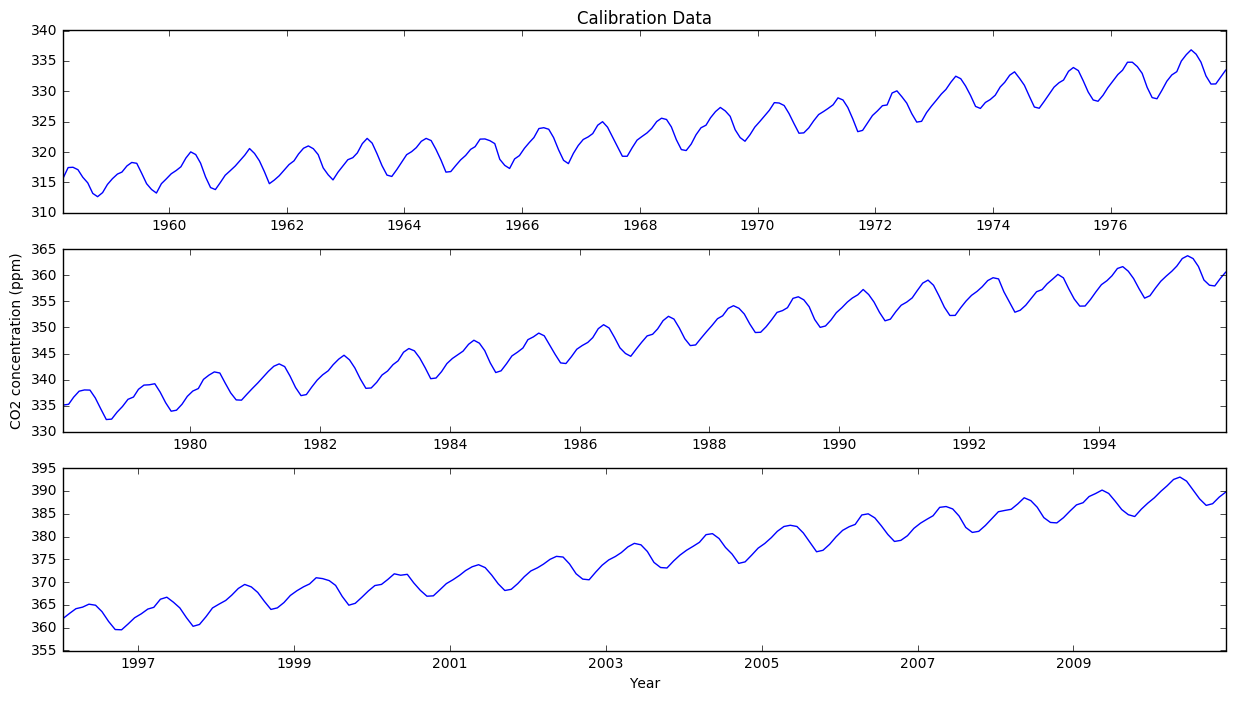

In [9]:
# Split the data into three plots to see the calibration
# data better
fig = plt.figure(figsize=(15,8))
plt.subplot(311)
plt.title('Calibration Data')
plt.plot(data['interpolated_CO2']['1958':'1977'])
plt.subplot(312)
plt.plot(data['interpolated_CO2']['1978':'1995'])
plt.ylabel('CO2 concentration (ppm)')
plt.subplot(313)
plt.plot(data['interpolated_CO2']['1996':'2010'])
plt.xlabel('Year')

<b>
Visually, it's clear that the data are not stationary, but quantitative measures can show non-stationarity too.

The variance may be essentially constant over time, but the mean rises over time.  This suggests that the time series is not stationary.  However, the nearly linear trend (rather than a strong exponential rise, for example) suggest that only one order of differencing is needed.

Let's check some other quantitative measures...

</b>

In [10]:
# One test is the Durbin-Watson statistic for serial correlation (autocorrelation)
# [0,2): positive autocorrelation
# (2,4]: negative autocorrelation
# 2: no autocorrelation

print(DW(data[:'2010']))

[  1.21917700e-05]


<b>
This small value (close to zero) suggests that the data have positive autocorrelation and are not stationary.

Another test of stationarity is the Dickey-Fuller test, which can reveal the presence of a unit root (unit eigenvalue) in an autoregressive model.  I.e., the time series is dominated by random behavior (unit eigenvalue or smaller), not a trend in any particular direction (larger eigenvalue).  So if the unit root appears to be present, we can claim stationarity.

</b>

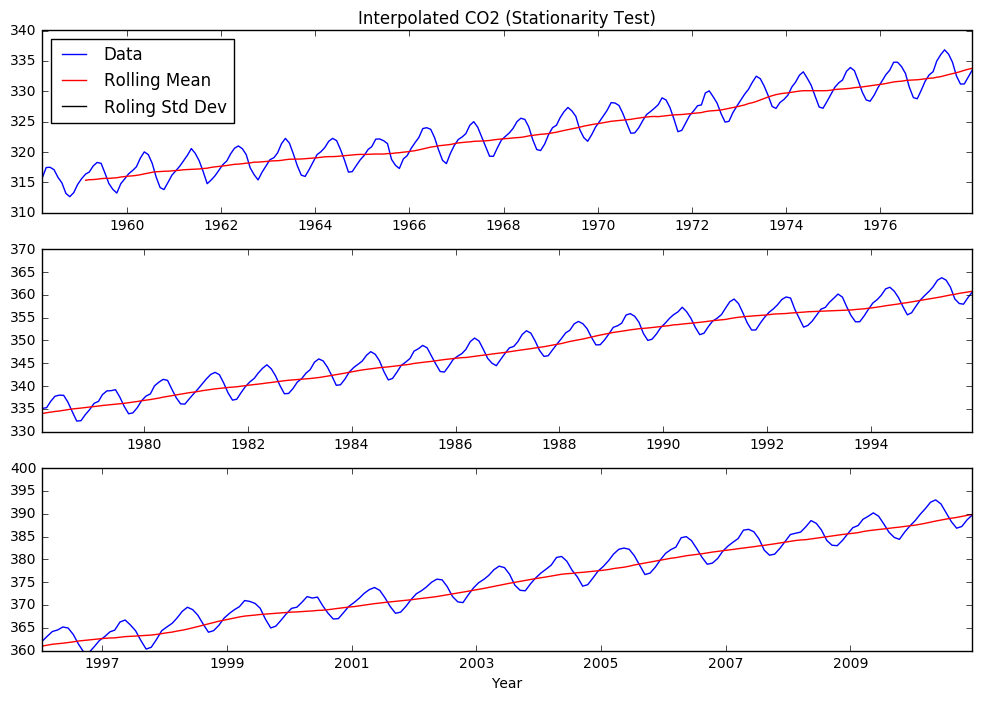

Results of Dickey-Fuller test:
Test Statistic                   4.164965
p-value                          1.000000
Lags Used                       20.000000
Number of Observations Used    613.000000
Critical Value (1%)             -3.441063
Critical Value (10%)            -2.569287
Critical Value (5%)             -2.866266
dtype: float64


In [11]:
# test_stationarity3(time_series, plot_title, y_lim)

ts_temp = pd.Series(np.array(data['interpolated_CO2'][:'2010']), name='interpolated_CO2', 
                    index=data[:'2010'].index.values)
test_stationarity3(ts_temp,'Interpolated CO2', [310,340],[330,370],[360,400])

<b>
It's already obvious that the series is non-stationary, but these quantitative measures will help to show the degree of stationarity as it becomes less evident visually.

The test statistic is greater than the critical value (at even 90% confidence interval), and the p-value is one, both showing that the time series is non-stationary.  These values will both decrease with increasing stationarity.

Ultimately, we will model the time series with the SARIMA model, but first we need to determine the parameters needed for the model.  To determine them, we can try manipulating the time series to see what is most effective.

First try removing the trend in the mean (rising through time) by applying a single order of differencing to the series.

</b>

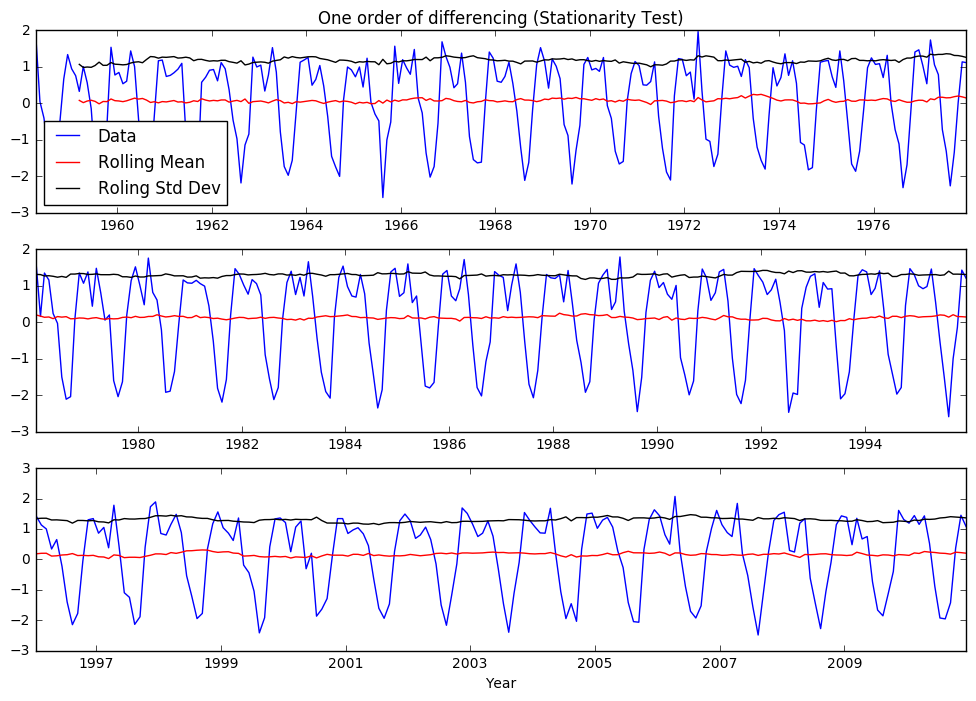

Results of Dickey-Fuller test:
Test Statistic                  -5.272471
p-value                          0.000006
Lags Used                       20.000000
Number of Observations Used    612.000000
Critical Value (1%)             -3.441080
Critical Value (10%)            -2.569291
Critical Value (5%)             -2.866274
dtype: float64


In [12]:
# Remove trend in mean by differencing (does not remove seasonality)

data['Differenced'] = data['interpolated_CO2'][:'2010'] - data['interpolated_CO2'][:'2010'].shift(1)
data['Differenced'].dropna(inplace=True)
test_stationarity3(data['Differenced'],'One order of differencing', [],[],[])

<b>
This has removed most of the trend in the mean (non-seasonal trend).  The plots show that the mean is essentially constant but still slightly above zero.  The test stat is much lower than the 99% CI critical value, and the p-value is zero.  These are all indicators that the series is much closer to stationary with respect to the trend of the series over the long-term.

Let's further consider the order of differencing.  Because the trend of the series is not constant over time, we would probably want two orders of differencing, but because the mean is very close to zero, I suspect another order of differencing would be too much and lead to an overfit model.

Despite the near-zero mean, there is still a seasonal component in the data (within each year, the data decrease and then increase, following the same pattern each year).

To examine the seasonal component more carefully, we can use autocorrelation functions.  In using these functions, we assume the data follow Gaussian distribution with predictable mean and standard deviation.  This appears to be a safe assumption considering the nearly constant mean and standard deviation in the stationarity plot.

</b>

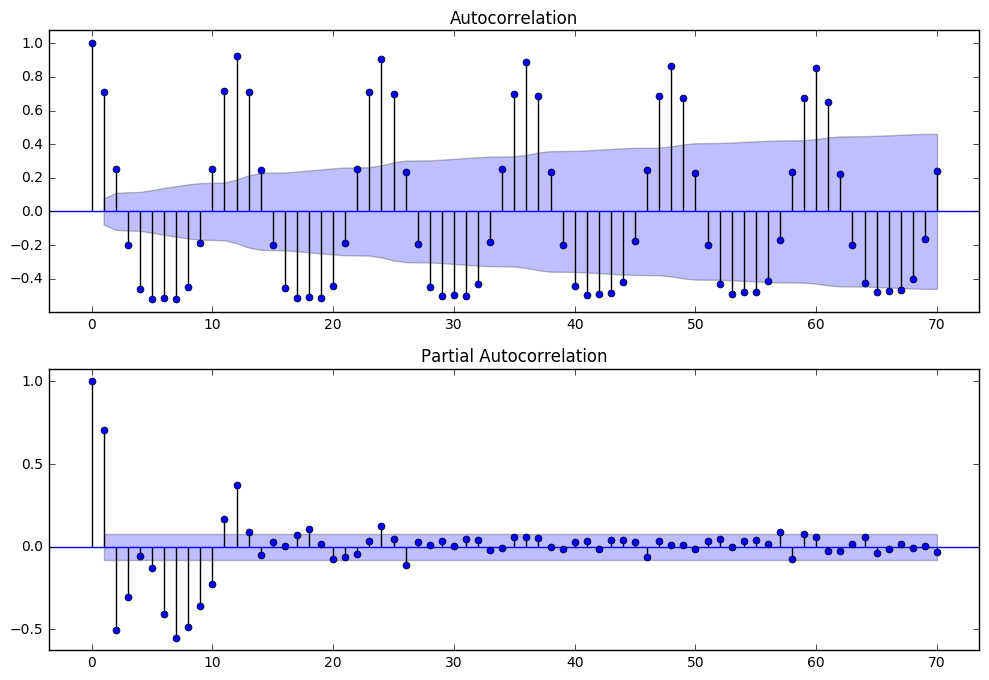

In [13]:
# Autocorrelation tests for seasonal stationarity
# Plot the autocorrelation and the partial autocorrelation
test_acfs(data['Differenced'],70)

<b>
These functions help us understand how much a lag (kn) is influenced by another lag (k1).  The autocorrelation shows the whole influence, including the indirect influence of k1 on kn, which includes the cumulative sum of the influences of k1 on k2, k2 on k3, ... kn-1 on kn.  The partial autocorrelation shows the direct influences between the lags, so in this case it would be how much k1 directly influences kn when leaving out the cumulative effects of the other lags.

In the autocorrelation plot above, at every 12-lag interval, the value is approximately the same, so there is a seasonal period of 12 months.  This reflects the consistent rise in CO2 over a 12 month period.  Even though the concentrations rise and fall, over any 12-month period, you can expect the CO2 levels to change by the same magnitude.

The partial autocorrelation plot shows values outside the 95% confidence envelope until perhaps 18 or 24 lags.  Because the partial autocorrelation can reveal direct influence of one lag on another, we can see that the influence is strong in neighboring lags, say less than 12 lags away, but diminishes rapidly.  More specifically, lag k0 is strongly influenced by k1, and also strongly influenced by k2.  K4, however, has a very small, perhaps insignificant influence on k0.  Imagine that the CO2 concentrations were unusually high in month 5, then we would expect them to be unusually high one lag away in month 6.  However, in month 9, the unusually high concentration of month 5 would not have a strong direct influence.  It does have an indirect influence because the cumulative rise in CO2 is certainly affected.

At this point it is obvious that the mean trend has been removed and the seasonal component remains.  However, we can check the Durbin-Watson statistic again to see if it has changed much from only one order of differencing.

</b>


In [14]:
# Check the Durbin-Watson statistic again
# [0,2): positive autocorrelation
# (2,4]: negative autocorrelation
# 2: no autocorrelation

print(DW(data['Differenced']))

0.575206138553


<b>
The value is now closer to 2, suggesting a decrease in autocorrelation (the residuals are becoming more independent of each other, or more random).

Let's try seasonal differencing over the period (number of lags, 12) determined from the autocorrelation plot.

</b>

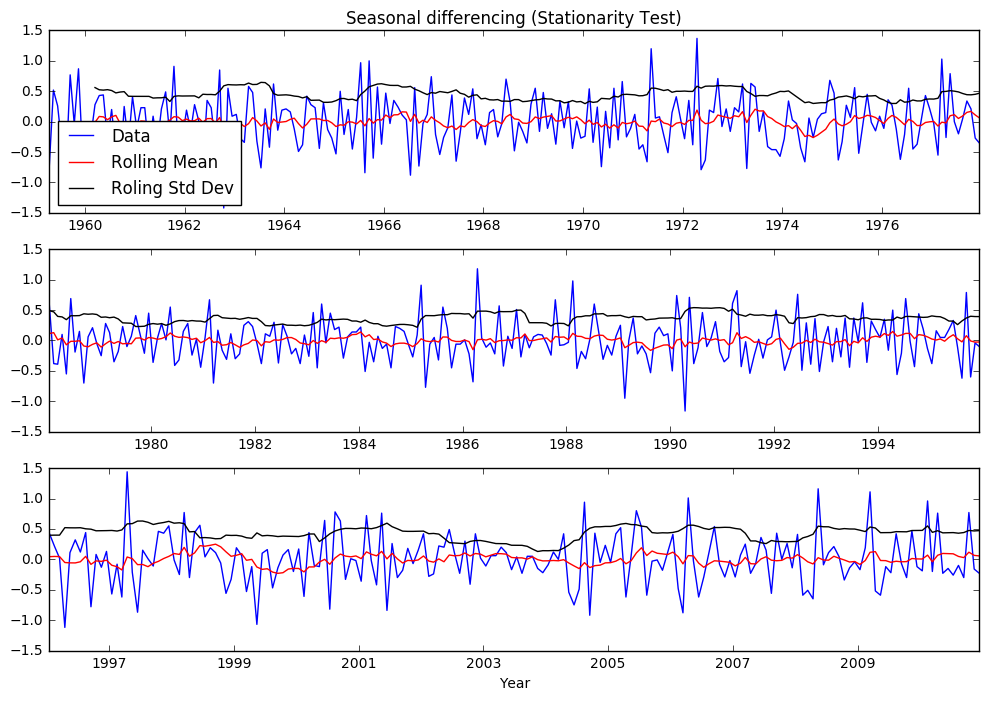

Results of Dickey-Fuller test:
Test Statistic                -1.010407e+01
p-value                        1.041062e-17
Lags Used                      1.200000e+01
Number of Observations Used    6.080000e+02
Critical Value (1%)           -3.441151e+00
Critical Value (10%)          -2.569308e+00
Critical Value (5%)           -2.866305e+00
dtype: float64


In [15]:
# Try seasonal differencing to remove the 12-month seasonal period.

data['Diff_Seasonal'] = data['Differenced'] - data['Differenced'].shift(12)
data['Diff_Seasonal'].dropna(inplace=True)
test_stationarity3(data['Diff_Seasonal'],'Seasonal differencing', [],[],[])

In [16]:
# Check the Durbin-Watson statistic again
# [0,2): positive autocorrelation
# (2,4]: negative autocorrelation
# 2: no autocorrelation

print(DW(data['Diff_Seasonal']))

2.57873825363


<b>
From the plots, the seasonal component appears to have been removed and the data look stationary, meaning that there appears to be no seasonal pattern and the residual series appears to be random over time (more like white noise than a repeating pattern).  Also, the standard deviation has been reduced to a small value, the test statistic is much less than the critical value at 99% confidence, and the p-value is essentially zero.

The Durbin-Watson statistic is closer to 2, suggesting lower autocorrelation.  Because the value is larger than 2, there might be negative autocorrelation present, which would produce a nice distribution of points about the mean, i.e., more precise mean.

Let's look at the autocorrelation functions again.

</b>

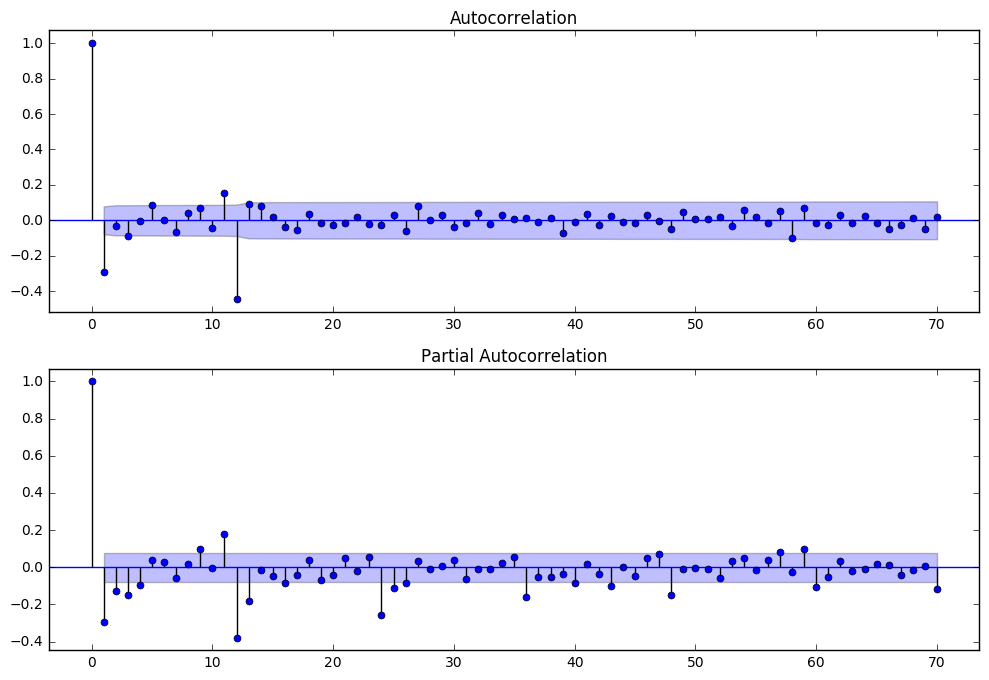

In [17]:
# Check the AC functions
test_acfs(data['Diff_Seasonal'],70)

<b>
Now the autocorrelations are very small for most lags (within 95% confidence envelope) and do not show a strong periodic pattern.  Instead, randomness seems to be stronger.  The partial autocorrelation is similar.  The plots still show a slight pattern (e.g., both plots show a subtle increase from lag 1 to lag 12).  I have tried additional orders of differencing (not shown) to see if the subtle pattern could be removed, but the results tends to be an overfit series with very little change in the statistical measures.

We can use the plots to estimate appropriate parameters for the SARIMA model.  There are several rules one can use (do a web search for these rules and several sites should be returned, including one from Duke University).

The sharp drop from lags 0 to 1 in each plot suggests that the data probably need a single MA term (from the ACF) and a single AR term (from the PACF), and because these are derived from seasonal data, the AR and MA terms will be in the seasonal portion of the model.  However, the low test statistic (above) and the very immediate cutoff in the autocorrelation functions might be indicating that only one of these terms might be needed to successfully model the data.  We can keep this in mind going forward.

We will also keep in mind that the series might need more than just one order of differencing in the ARIMA portion of the model.  The evidence is in the non-linear slope of the mean trend, and in the inability to fully remove non-stationarity from the mean using one order of differencing.

</b>

## Construct a model

<b>
Now that we have examined the data and found the functions that produce a stationary series, we can try making a model starting with those values and perhaps adding other terms (AR or MA) to help fit the trend in the mean.

Summary:  The data appear to need...
* one differencing term (single order) for the non-seasonal trend
* one seasonal differencing term for the seasonal trend
* one seasonal AR term
* one seasonal MA term

For the model SARIMAX(p,d,q) x (P,D,Q,s), non-seasonal ordering is specified by p, d, and q, where...
* p = number of AR terms
* d = order of differencing (integration)
* q = number of MA terms
and seasonal ordering is specified by...
* P = number of AR terms
* D = order of differencing (integration)
* Q = number of MA terms
* s = seasonal period (e.g., 12 for a 12-month period)

The starting model: (0,1,0)(1,1,1,12)

</b>

### Model 1

                                 Statespace Model Results                                 
Dep. Variable:                   interpolated_CO2   No. Observations:                  634
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -172.189
Date:                            Wed, 28 Dec 2016   AIC                            350.377
Time:                                    16:32:38   BIC                            363.733
Sample:                                03-15-1958   HQIC                           355.564
                                     - 12-15-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0453      0.042      1.069      0.285      -0.038       0.128
ma.S.L12      -0.9197      0.024   

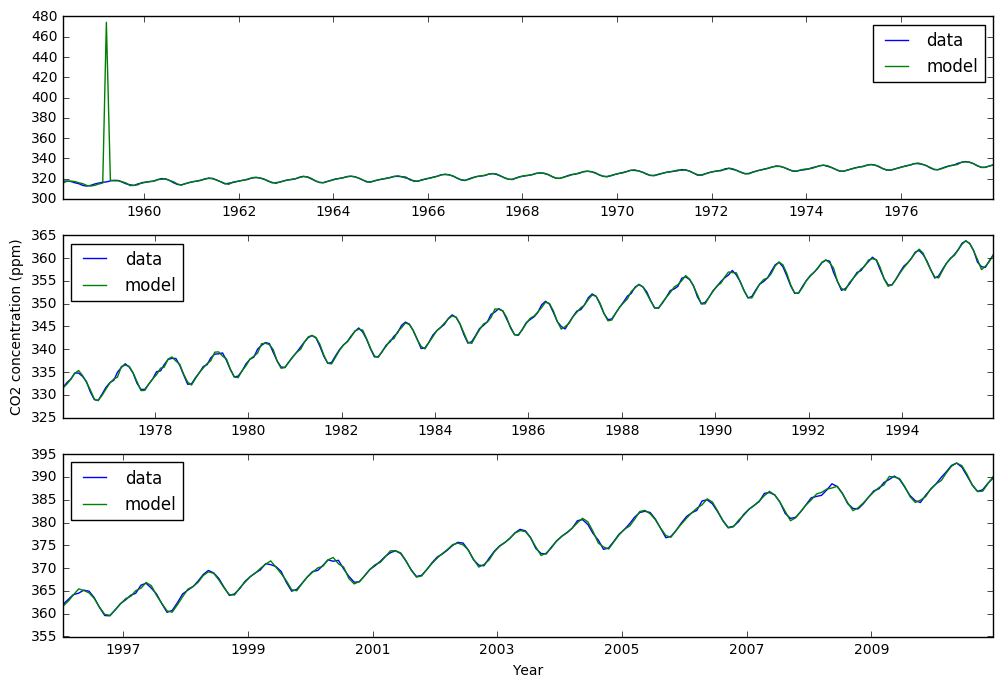

In [18]:
# Make the first model
# (0,1,0)(1,1,1,12)

model1, model1_fit, model1_results = make_SARIMAX(data['interpolated_CO2'][:'2010'],[0,1,0],[1,1,1,12])

<b>
Despite one unstable point (spike) in the modeled values near 1961, the fit appears to be excellent.  Let's keep an eye on the log likelihood, AIC, BIC, and HQIC values to see if the fit improves.  Log likelihood will increase (smaller magnitude because negative) and the others will get smaller with an improved fit.

I've tried a few different models by varying p, d, and q for the ARIMA and seasonal components, and the one that produces a statistically better fit includes two MA terms.

</b>

### Model 2

                                 Statespace Model Results                                 
Dep. Variable:                   interpolated_CO2   No. Observations:                  634
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -137.890
Date:                            Wed, 28 Dec 2016   AIC                            285.779
Time:                                    16:32:41   BIC                            308.039
Sample:                                03-15-1958   HQIC                           294.423
                                     - 12-15-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3525      0.039     -9.090      0.000      -0.429      -0.277
ma.L2         -0.0700      0.039   

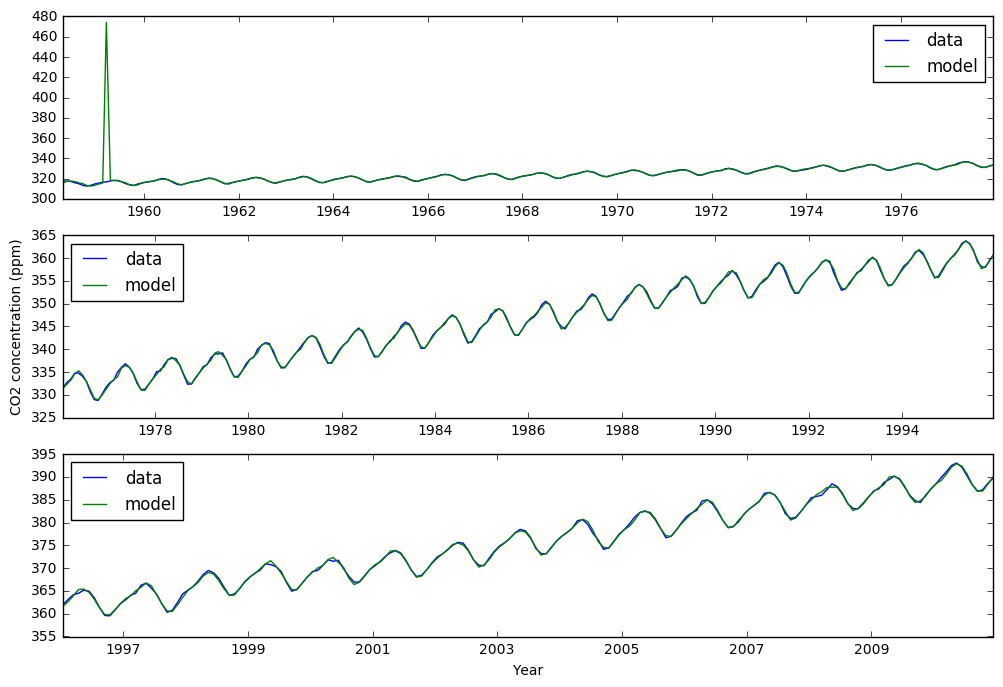

In [19]:
# Try another model that includes two MA terms.

model2, model2_fit, model2_results = make_SARIMAX(data['interpolated_CO2'][:'2010'],[0,1,2],[1,1,1,12])

<b>
The statistical measures are all improved, so it appears that the fit is slightly better even though it's not apparent from looking at the plot.

We can check to see how well each model performs by using each one to predict the holdout data.  The prediction will start before the end of the calibration data (2010-12) and continue to the end of the dataset (2016-09), encompassing the holdout data.  Because this prediction will extend outside of the calibration, it is considered an out-of-sample prediction.

</b>

### Model 1 Prediction


RMS Error within forecast dates: 1.7639 



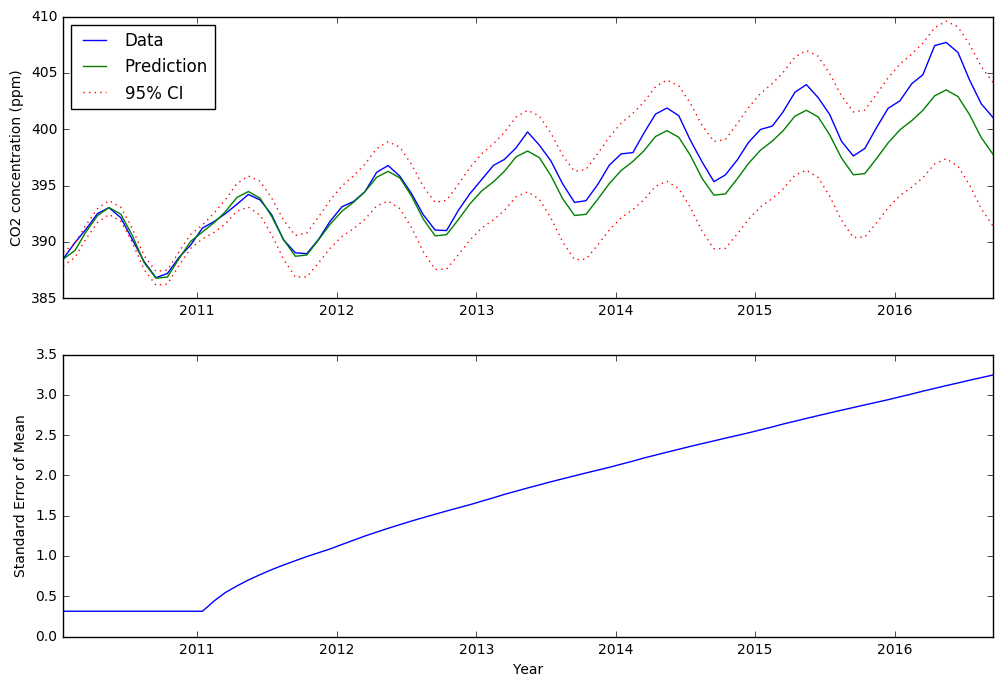

In [20]:
# Try an out-of-sample prediction using model 1.

# Establish start and end dates of the prediction and format some of them.
start_str = '2010-01-15'
end_str = '2016-09-15'
start_date = pd.to_datetime(start_str)
end_date = pd.to_datetime(end_str)
start_date_ord = data.index.get_loc(start_date)
end_date_ord = data.index.get_loc(end_date)


# Get the prediction
pred_results = model1_results.get_prediction(start=start_date_ord, end=end_date_ord)
pred_summary = pred_results.summary_frame(alpha=0.05)


# Make date indices for the prediction results.  The results will have indices in 
# ordinal values, so this will replace them with dates for easier plotting and analysis.
try:
    del dates
except NameError:
    pass

dates = pd.DataFrame(data.ix[pred_summary.index.tolist()].index, columns=['DateTime'])
pred_summary = pred_summary.set_index(dates['DateTime'])


# Check the RMSE
orig = np.array(data['interpolated_CO2']['2011':'2016'])
pred = np.array(pred_summary['2011':'2016'].ix[:,0])
RMSE = np.sqrt(sum((pred-orig)**2)/len(orig))
print()
print('RMS Error within forecast dates: %0.4f ' %RMSE)
print()


# Plot the results to see how the prediction compares with the data
compare_prediction(data['interpolated_CO2'][start_date:end_date], pred_summary[start_date:end_date])

### Model 2 Prediction


RMS Error within forecast dates: 1.3380 



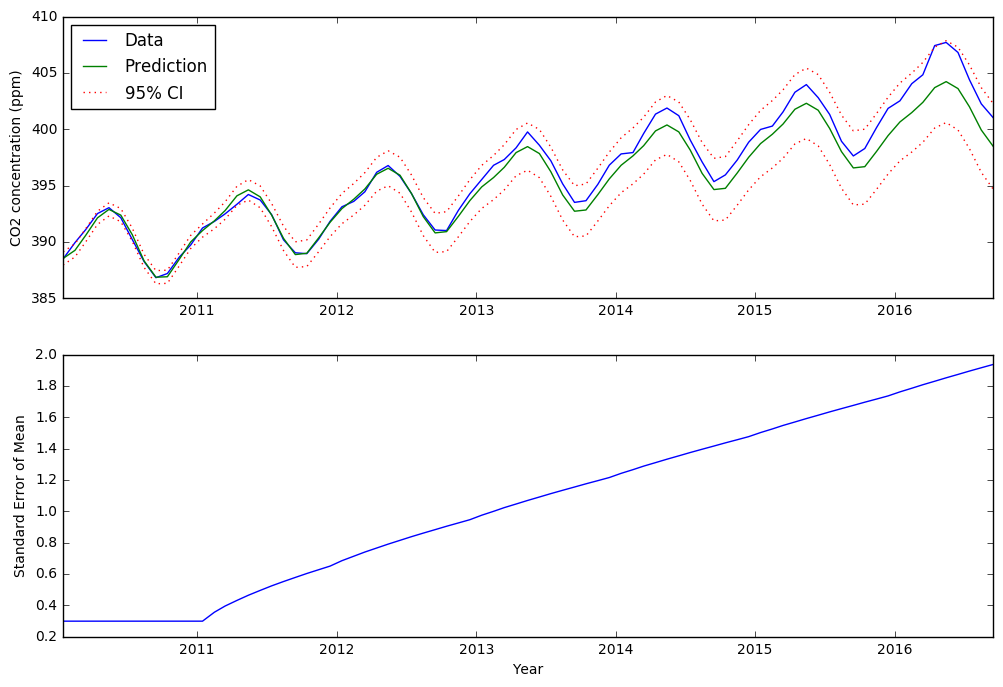

In [21]:
# Try an out-of-sample prediction using model 2.

# Establish start and end dates of the prediction and format some of them.
start_str = '2010-01-15'
end_str = '2016-09-15'
start_date = pd.to_datetime(start_str)
end_date = pd.to_datetime(end_str)
start_date_ord = data.index.get_loc(start_date)
end_date_ord = data.index.get_loc(end_date)


# Get the prediction
pred_results = model2_results.get_prediction(start=start_date_ord, end=end_date_ord)
pred_summary = pred_results.summary_frame(alpha=0.05)


# Make date indices for the prediction results.  The results will have indices in 
# ordinal values, so this will replace them with dates for easier plotting and analysis.
try:
    del dates
except NameError:
    pass

dates = pd.DataFrame(data.ix[pred_summary.index.tolist()].index, columns=['DateTime'])
pred_summary = pred_summary.set_index(dates['DateTime'])


# Check the RMSE
orig = np.array(data['interpolated_CO2']['2011':'2016'])
pred = np.array(pred_summary['2011':'2016'].ix[:,0])
RMSE = np.sqrt(sum((pred-orig)**2)/len(orig))
print()
print('RMS Error within forecast dates: %0.4f ' %RMSE)
print()


# Plot the results to see how the prediction compares with the data
compare_prediction(data['interpolated_CO2'][start_date:end_date], pred_summary[start_date:end_date])

<b>
Before comparing the models, notice that the standard error is very low for the in-sample portion of the prediction.  An in-sample prediction should be the best we hope to achieve, so it is expected to have the low error values.  The out-of-sample forecast starts at 2011-01, so the standard error rises from that date.

We can see in the plots that model 1 (0,1,0)x(1,1,1,12) does not fit the holdout data quite as well as model 2 (0,1,2)x(1,1,1,12).  Notice also the RMS error is slightly lower in model 2.

In both model models, the forecasted values clearly get less predictable with time, which we should expect considering we are trying to predict the future and the further our forecast is from the last known data, the worse it should be.  A SARIMA model is not expected to predict far into the future because every new forecasted point is based on the previous points, which are also forecasted and contain error.  Those errors can add up quickly.  It appears that these models do pretty well up to about two to three years from the last measured data point, so from the start of 2011 to the end of 2012 or maybe even 2013, the forecasts are pretty good.  Statistically, the forecasts are within the 95% confidence interval through 2016, so that is a good result, but we can clearly see that the prediction underestimates the actual measurements more so with time.

The underestimate might be due to the slightly non-linear rise in the mean of the data.  A single order of differencing generally works for a linear trend, and a second order of differencing should work for a non-linear trend, but when two orders of differencing were attempted, the model fit became worse and gave signs of overfitting.  The addition of the two MA terms was not enough to fully correct the misfit.

A possible solution to a better model fit may be to include exogenous regressors to boost the rise in the mean, but I'll leave that for another day.  For now, let's see how a forecast (beyond the measured data) looks.

</b>

## Forecast using Model 2



In [22]:
# Extend the indices of the dataframe for the prediction
start_str = '2016-10-15'
end_str = '2019-10-15'
start_date = pd.to_datetime(start_str)
end_date = pd.to_datetime(end_str)


# Get the start date index
# Ensure the start date of the data is within the data index
start_date_ord = len(data['interpolated_CO2']) - 1
date_max = data.index[start_date_ord]

if start_date < date_max:
    start_date_ord = data.index.get_loc(start_date)


# Calculate the end date index
start_parsed = start_str.split('-')
end_parsed = end_str.split('-')

y = int(end_parsed[0]) - int(start_parsed[0])
m = int(end_parsed[1]) - int(start_parsed[1])

if m > 12:
    print('Months are too high.  Try again.')
    print('Setting date range to 0.')
    T_m = 0
    
else:
    if y > 0:
        y = y*12
        T_m = y + m

    elif y < 0:
        print('End date must be after start date.')
        print('Setting date range to 0.')
        T_m = 0

    elif y == 0 and m < 0:
        print('End date must be after start date.')
        print('Setting date range to 0.')
        T_m = 0

end_date_ord = start_date_ord + T_m

                                 Statespace Model Results                                 
Dep. Variable:                   interpolated_CO2   No. Observations:                  703
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -169.472
Date:                            Wed, 28 Dec 2016   AIC                            348.945
Time:                                    16:32:45   BIC                            371.721
Sample:                                03-15-1958   HQIC                           357.747
                                     - 09-15-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3545      0.038     -9.422      0.000      -0.428      -0.281
ma.L2         -0.0750      0.035   

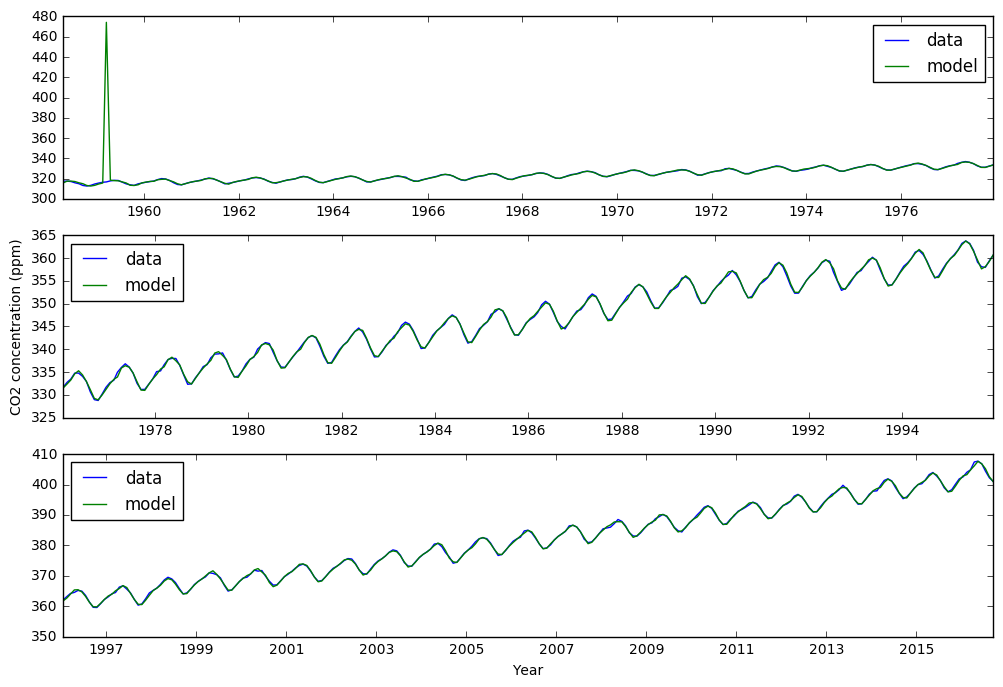

In [23]:
# Create model for use in out-of-sample predictions
model2_out, model2_out_fit, model2_out_results = make_SARIMAX(
    data['interpolated_CO2'][:'2016'],[0,1,2],[1,1,1,12])

In [24]:
# Get the prediction model
try:
    del pred_results
except NameError:
    pass

try:
    del pred_summary
except NameError:
    pass

pred_results = model2_out_results.get_prediction(start=start_date_ord, end=end_date_ord)
pred_summary = pred_results.summary_frame(alpha=0.05)

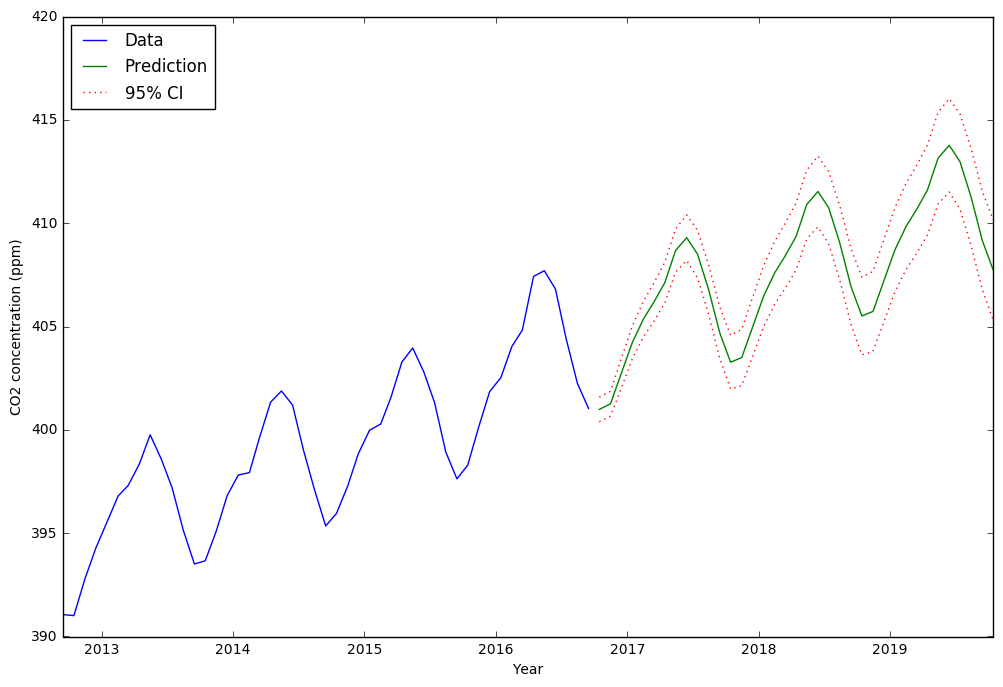

In [25]:
# Prediction

# Convert dates to dataframe indices for appending to data
future_dates = pd.date_range(start=start_str, end=end_str, freq='2SMS', columns='DateTime')
pred_summary_dates = pred_summary.set_index(future_dates)


# Show some measured data
start_date_ord = start_date_ord - 48


# Plot the results to see the forecast
plt.plot(data['interpolated_CO2'].ix[start_date_ord:end_date_ord], 'b', label='Data')
plt.plot(pred_summary_dates['mean'][start_date:end_date], 'g', label='Prediction')
plt.plot(pred_summary_dates['mean_ci_lower'][start_date:end_date], 'r:', label='95% CI')
plt.plot(pred_summary_dates['mean_ci_upper'][start_date:end_date], 'r:', label='_nolegend_')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Year')
plt.legend(loc='best')
plt.savefig('CO2_forecast.png')

<b>
Although the forecast is an underestimate, it should provide estimates that are pretty close to the atmospheric CO2 levels (within about 2-3 years of the last measurement).

With addition of exogenous regressors to this model, or even switching to a Fourier approach, an improved model can be constructed that would better estimate CO2 levels further into the future.

</b>